Dividiendo documentos largos en subsecuencias
=============================================

## Introducción

Las secuencias de texto con las que trabajamos podrían ser de una cantidad de palabras infinita, sin embargo, en computación sabemos que no existe poder de computo infinito y por lo tanto es necesario imponer restricciones en las dimensiones de nuestros datos de entrada. Dependiendo de los requisitos computacionales del modelo con el que estamos trabajando y sus supociones, será entonces la longitud máxima de texto sobre la que podemos trabajar. Modelos complejos pondrán mayor presión de recursos de hardware y por lo tanto podrían ser más restrictivos con la cantidad de palabras que podemos procesar.

Tenemos varias opciones para resolver esta limitación:

- Truncar las secuencias a la máxima longitud disponible, con la esperanza de que toda la información relevante esté en la secuencia resultante. Claramente aquí perderá información y dependerá de la cantidad de información que piede si es una alternativa viable o no.
- Utilizar un modelo que opere sobre secuencias más largas
- Ejecutar el modelo sobre subsecuencias más pequeñas y luego entrenar un metamodelo que tome las predicciones de cada secuencia y las combine.
- Dividir la secuencia en subsecuencias de un tamaño menos pero manteniendo algo del contexto de la subsecuencia anterior a la que estamos procesando. Luego ejecutar nuestro modelo tratando a cada subsecuencia como un documento distinto. Las predicciones de todas las subsecuencias luego son agregadas utilizando alguna función. Para ver un ejemplo de esto ultimo vea Dividiendo documentos largos en subsecuencias.

En este ejemplo exploraremos como realizar la última opción:

### Preparación del ambiente

Instalamos las librerías necesarias

In [1]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/m72109/nlp/transformation.py \
  --no-clobber --quiet --directory-prefix ./m72109/nlp/
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/nlp/preprocessing/long_sequences.txt \
  --no-clobber --quiet
!pip install -r long_sequences.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.3/320.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.7 MB/s eta 0:00:00


### Sobre el conjunto de datos a utilizar

En este caso, no podremos trabajar con el conjnto de datos que veniamos trabajando anteriormente ya que los tweets en general son secuencias de texto cortas de hasta 140 caracateres. Es decir que nuestros modelos probablemente nunca se encuentren con el problema de longitudes largas en el texto.

Para demostrar este ejemplo, utilizaremos el conjunto de datos "20 grupos de notificas". El conjunto de datos comprende alrededor de 18000 publicaciones de grupos de noticias sobre 20 temas distintos, desde deportes hasta noticias relacioandas con la aeronáutica.

Para realizar el trabajo más sencillo, solo traeremos noticias de los grupos 'alt.atheism' y 'sci.space'.

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

Podemos ver que este conjunto de datos dispone de la siguiente cantidad de muestras:

In [2]:
print("Cantidad de textos:", len(newsgroups_train.data), "\nCantidad de anotaciones:", newsgroups_train.target.shape[0])

Cantidad de textos: 1073 
Cantidad de anotaciones: 1073


Creemos un `pd.DataFrame` de `pandas` para que sea más fácil manipular los datos:

In [3]:
import pandas as pd

df = pd.DataFrame({ 'text': newsgroups_train.data, 'category': newsgroups_train.target })

## Resolviendo las limitaciones de longitud de texto

Primero, revisemos las longitudes de los documentos que tenemos para tener una idea de que tan largos pueden llegar a ser. Primero dividiremos el mismo en palabras y luego generaremos un histograma para revisar que tan frecuentemente hay documentos con cada longitud:

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'])

tokenized_text = tokenizer.texts_to_sequences(df['text'])

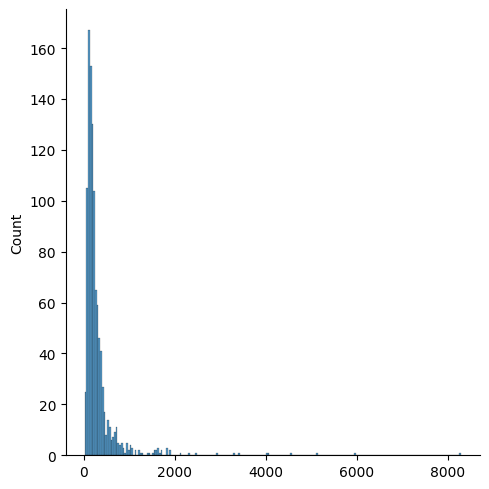

In [5]:
text_lens = [len(n) for n in tokenized_text]

import seaborn as sns
sns.displot(text_lens)

Vemos que tenemos varios documentos que tienen más de 1000 palabras.

#### Dividir las secuencias en subsecuencias

Supongamos que el modelo del que disponemos **no puede procesar secuencias de mas de 200 palabras**. ¿Cómo resolver esta limitación y aplicar el modelo sobre este conjunto de datos?

Crearemos una funcion `split_text_with_context` que toma un texto de cantidad arbitraria de palabras y lo transforma en un arreglo de M textos o secuencias donde cada secuencia tiene como máximo `unique_words + context_words` palabras. Cada secuencia comienza con `context_words` palabras de la secuencia anterior para poder retener el contexto de la oración, generando así un *rolling window*.

Como ejemplo, la siguiente imágen muestra un texto donde se aplicó esta transformación utilizando `context_words=3` y `unique_words=2`

<img src='https://github.com/santiagxf/M72109/blob/master/docs/nlp/_images/rolling_text.png?raw=1' />

La función la hemos implementado de la siguiente forma:

In [6]:
from m72109.nlp.transformation import split_text_with_context

> Nota: El siguiente codigo simplemente muestra la implementación de la función. Su utilización es simplemente educativa.

In [25]:
from inspect import getsource
print(getsource(split_text_with_context))

def split_text_with_context(text: str, unique_words: int = 150, context_words: int = 50) -> List[str]:
    """
    Divide una secuencia de palabras de longitud arbitraria en una lista de secuencias de no mas que
    `context_words + unique_words` palabras. Cada subsecuencia tendra `unique_words` palabras del texto
    original y las restantes palabras seran arrastradas de la subsecuencia anterior para manetener el 
    contexto de la oración.

    Parameters
    ----------
    text : str
        El texto que queremos dividir en subsequencias.
    unique_words : int
        Cantidad de palabras únicas que deben manetenerse en cada subsecuencia.
    context_words : int
        Cantidad de palabras que deben traerse de la subsequencia anterior como contexto.

    Returns
    -------
    List[str]
        A list of sub-sequences of text of no more than `unique_words` + `context_words`.
    """

    words = text.split()
    num_seqs = math.ceil(len(words)/unique_words)

    seqs = [' '.join

Verifiquemos como se aplica en uno de los textos que tenemos disponibles. Buscaremos un texto con 1200 caracteres:

In [7]:
long_sequences = df.loc[df.text.str.len() > 1200]

In [8]:
sample_text = long_sequences['text'].iloc[0]
print(sample_text)

From: jhwitten@cs.ruu.nl (Jurriaan Wittenberg)
Subject: Re: Magellan Update - 04/16/93
Organization: Utrecht University, Dept. of Computer Science
Keywords: Magellan, JPL
Lines: 29

In <19APR199320262420@kelvin.jpl.nasa.gov> baalke@kelvin.jpl.nasa.gov 
(Ron Baalke) writes:

>Forwarded from Doug Griffith, Magellan Project Manager
>
>                        MAGELLAN STATUS REPORT
>                            April 16, 1993
>
>
>2.  Magellan has completed 7225 orbits of Venus and is now 39 days from
>the end of Cycle-4 and the start of the Transition Experiment.
Sorry I think I missed a bit of info on this Transition Experiment. What is it?

>4.  On Monday morning, April 19, the moon will occult Venus and
>interrupt the tracking of Magellan for about 68 minutes.
Will this mean a loss of data or will the Magellan transmit data later on ??

BTW: When will NASA cut off the connection with Magellan?? Not that I am
looking forward to that day but I am just curious. I believe it had something
t

In [9]:
transformed = split_text_with_context(sample_text, 40, 20)

for sequence in transformed:
  print('********')
  print(sequence)

********
From: jhwitten@cs.ruu.nl (Jurriaan Wittenberg) Subject: Re: Magellan Update - 04/16/93 Organization: Utrecht University, Dept. of Computer Science Keywords: Magellan, JPL Lines: 29 In <19APR199320262420@kelvin.jpl.nasa.gov> baalke@kelvin.jpl.nasa.gov (Ron Baalke) writes: >Forwarded from Doug Griffith, Magellan Project Manager > > MAGELLAN STATUS REPORT
********
Lines: 29 In <19APR199320262420@kelvin.jpl.nasa.gov> baalke@kelvin.jpl.nasa.gov (Ron Baalke) writes: >Forwarded from Doug Griffith, Magellan Project Manager > > MAGELLAN STATUS REPORT > April 16, 1993 > > >2. Magellan has completed 7225 orbits of Venus and is now 39 days from >the end of Cycle-4 and the start of the Transition Experiment. Sorry I think I missed a bit of info
********
>the end of Cycle-4 and the start of the Transition Experiment. Sorry I think I missed a bit of info on this Transition Experiment. What is it? >4. On Monday morning, April 19, the moon will occult Venus and >interrupt the tracking of Magel

Apliquemoslo sobre todo el dataset:

In [10]:
df.loc[:,'text'] = df['text'].apply(split_text_with_context)

#### Generando un nuevo dataset para entrenar el modelo

Hasta el momento disponemos de un dataset donde una de sus columnas es un arreglo de secuencias de texto. Esta estructura de datos no puede ser utilizada con un modelo de procesamiento de texto y por lo tanto es necesario "aplanarla". Esto quiere decir que debemos convertir los elementos del arreglo en filas de nuestro dataset.

El método `explode` transforma un data frame donde una de sus columnas es un arreglo, en otro data frame donde los elementos del arreglo se transforman en filas y los restantes valores son duplicados. Este método nos ayudará en este caso a que todas las subsecuencias que se generaron de la misma secuencia reciban los mismos valores para las restantes columnas (como por ejemplo, la variable a predecir). El efecto de explode es el siguiente:

<img src='https://github.com/santiagxf/M72109/blob/master/docs/nlp/_images/explode.png?raw=1' />

In [11]:
df = df.explode('text').reset_index(drop=True)

In [12]:
df.shape

(2814, 2)

> Note como pasamos de tener 1073 filas a tener 2119. Las filas extras que se agregaron corresponden a secuencias de texto que eran demasiado largas y que fueron divididas en subsecuencias, aunque manteniendo la misma anotación de la secuencia original.

Resultado final

In [13]:
df.head(10)

,text,category
0,From: bil@okcforum.osrhe.edu (Bill Conner) Sub...,0
1,From: jhwitten@cs.ruu.nl (Jurriaan Wittenberg)...,1
2,the tracking of Magellan for about 68 minutes....,1
3,From: sysmgr@king.eng.umd.edu (Doug Mohney) Su...,1
4,> >Nobody who is interested in launching thing...,1
5,little itty-bitty payloads in LEO with your la...,1
6,From: pgf@srl03.cacs.usl.edu (Phil G. Fraering...,1
7,gamma ray spectroscopy on distant asteroids wi...,1
8,From: Nanci Ann Miller <nm0w+@andrew.cmu.edu> ...,0
9,decided to improve both of their images on wha...,0
